## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
# Create a Neural Network class
class ThreeLayerNeuralNetwork:
    # Initialize the class
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate, activation_function, Optimizer): 
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        self.learning_rate = learning_rate
        self.activation_function = activation_function
        self.Optimizer = Optimizer

    def change_learning_rate(self, learning_rate):
        self.learning_rate = learning_rate

    def change_activation_function(self, activation_function):
        self.activation_function = activation_function

    def change_Optimizer(self, Optimizer):
        self.Optimizer = Optimizer

    def change_hidden_nodes(self, hidden_nodes):
        self.hidden_nodes = hidden_nodes

    def _init_weight_matrices(self, input_nodes, hidden_nodes, output_nodes):
        # Initialize the weight matrices with random values
        self.weight_matrix_1 = np.random.randn(input_nodes, hidden_nodes)
        self.weight_matrix_2 = np.random.randn(hidden_nodes, output_nodes)

    def _init_bias_vectors(self, input_nodes, hidden_nodes, output_nodes):
        # Initialize the Bias Vector 1
        # The Size of the Bias Vector 1 is (hidden_nodes, 1)
        self.bias_vector_1 = np.zeros((1, self.hidden_nodes))
        # The Size of the Bias Vector 2 is (output_nodes, 1)
        self.bias_vector_2 = np.zeros((1, self.output_nodes))

    def _loss_function(self, y, y_hat):
        return np.mean((y - y_hat)**2)
    
    def _loss_function_grad(self, y, y_hat):
        return 2 * (np.array(y_hat - y))/(y.shape[0])
    
    def _activation_function(self, x):
        # Write Code for the Tanh, activation function
        return np.tanh(x)
    
    def _grad_of_activation(self, x):
        # Gradient of Activation
        return 1 - np.square(np.tanh(x))

    def _forward_pass(self, input_vector):
        # The Size of the Input Vector is (input_nodes, 1)
        self.input_vector = input_vector
        # print("Input Vector: ", self.input_vector)
        # The Size of the Hidden Layer is (hidden_nodes, 1)
        self.input_vector = self.input_vector.T
        self.activation_layer = np.dot(input_vector, self.weight_matrix_1) 
        # print("Activation Layer: ", self.activation_layer)
        self.hidden_layer = self._activation_function(self.activation_layer) + self.bias_vector_1
        # The Size of the Output Layer is (output_nodes, 1) 
        self.output_layer = np.dot(self.hidden_layer, self.weight_matrix_2) + self.bias_vector_2
        # print('==============================================================================================') 
        print("Output Layer: ", self.output_layer.shape)
        return self.output_layer

    def _backward_pass(self,target_vector):
        # Basically we need to obtain derivatives with respect to two weight matrices
        target_vector = np.array(target_vector)
        # First With Weight Matrix 2
        target_vector = target_vector.reshape(-1, 1) # Reshape into a (no.of samples, 1) vector
        # First, we need to calculate the derivative of the loss function with respect to the output layer
        Loss_Derivative = self._loss_function_grad(target_vector, self.output_layer)
        Weight_Matrix_2_Derivative = np.dot(self.hidden_layer.T, Loss_Derivative)

        # # Now, Find the Bias Vector
        Bias_Vector_2_Derivative = np.sum(Loss_Derivative, axis=0, keepdims=True)

        # First, we need to calculate the derivative of the loss function with respect to the hidden layer
        Loss_Derivative = np.dot(self.weight_matrix_2, Loss_Derivative.T)
        # Second, we need to Calculate the derivative of the hidden layer with respect to the activation layer
        Activation_Layer_Derivative = self._grad_of_activation(self.activation_layer)
        # Here the Activation_Layer_Derivative is of shape (25, 1) -> Which is the same as the hidden layer -> Multiply element wise
        Temp_Dertivative = np.multiply(Activation_Layer_Derivative, Loss_Derivative.T)
        Weight_Matrix_1_Derivative = np.dot(self.input_vector, Temp_Dertivative)

        # Now, Find the Bias Vector
        Bias_Vector_1_Derivative = np.sum(Temp_Dertivative, axis=0, keepdims=True)
        
        # Now, we have the derivatives of the loss function with respect to the weight matrices
        # Now, we need to update the weight matrices
        # Update the Weight Matrix 1
        self.weight_matrix_1 = self.weight_matrix_1 - self.learning_rate * Weight_Matrix_1_Derivative
        self.bias_vector_1 = self.bias_vector_1 - self.learning_rate * Bias_Vector_1_Derivative
        # Update the Weight Matrix 2
        self.weight_matrix_2 = self.weight_matrix_2 - self.learning_rate * Weight_Matrix_2_Derivative
        self.bias_vector_2 = self.bias_vector_2 - self.learning_rate * Bias_Vector_2_Derivative

        # # Clear the Derivative Variables
        Weight_Matrix_1_Derivative = None
        Weight_Matrix_2_Derivative = None

    def Train(self, train_data_x, train_data_y, epochs):
        # Initialize the weights first
        self._init_weight_matrices(self.input_nodes, self.hidden_nodes, self.output_nodes)
        # Initialize the bias first
        self._init_bias_vectors(self.input_nodes, self.hidden_nodes, self.output_nodes)
        # Now, we need to train the model
        # We need to iterate over the training data
        # Plot the Losses Dynamically 

        # Create a figure and axis for dynamic plotting
        plt.ion()  # Turn on interactive mode for dynamic updates
        fig, ax = plt.subplots()

        losses = []

        for epoch in range(epochs):
            # Train the model
            self._forward_pass(train_data_x)
            self._backward_pass(train_data_y)

            # Create a copy of the train_data_y
            train_data_y_copy = train_data_y.copy()
            train_data_y_copy = train_data_y_copy.reshape(-1, 1)
            train_data_y_copy = train_data_y_copy.T
            print(train_data_y_copy.shape)

            loss = self._loss_function(train_data_y_copy, self.output_layer.T)
            losses.append(loss)

            # Print the loss
            # print('Epoch: ', epoch, 'Loss: ', loss)

        ax.clear()
        ax.plot(losses, label='Loss')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
        plt.pause(0.1)  # Pause for a short time to allow the plot to update
        
        plt.ioff()
        plt.show()

    def Test(self, data_point):
        # We need to iterate over the test data
        return self._forward_pass(data_point)

    def Predict(self, data_point):
        pass



## Load the Data

In [3]:
# Load the Data
data = pd.read_csv('./Concrete_Data.csv', header=None)
# Remove the First Row
data = data.iloc[1:]
# Print the Shape of the Data
print(data.shape)

# Target Variable 
target_variable = data.iloc[:, -1]
# Input Variables
input_variables = data.iloc[:, 0:8]

# Convert both to numpy arrays
target_variable = np.array(target_variable, dtype=np.float32)
input_variables = np.array(input_variables, dtype=np.float32)

print(target_variable.shape)
print(input_variables.shape)

# Preprocess the Data
########################

########################

# Split the Data into Train and Test
# Randomly choose 70% and 30% of the data
Total_samples = target_variable.shape[0]
Train_percentage = 0.7

Train_Samples = 0.7*Total_samples
Test_Samples = 0.3*Total_samples

# Shuffle The Data
indices = np.arange(Total_samples)
np.random.shuffle(indices)

# Split this data
Train_indices = indices[:int(Train_Samples)]
Test_indices = indices[int(Train_Samples):]

X_Train = input_variables[Train_indices]
Y_Train = target_variable[Train_indices]
x_test = input_variables[Test_indices]
y_test = target_variable[Test_indices]


(1030, 9)
(1030,)
(1030, 8)


# Training the Neural Network

Output Layer:  (721, 1)
(1, 721)
Output Layer:  (721, 1)
(1, 721)
Output Layer:  (721, 1)
(1, 721)
Output Layer:  (721, 1)
(1, 721)
Output Layer:  (721, 1)
(1, 721)
Output Layer:  (721, 1)
(1, 721)
Output Layer:  (721, 1)
(1, 721)
Output Layer:  (721, 1)
(1, 721)
Output Layer:  (721, 1)
(1, 721)
Output Layer:  (721, 1)
(1, 721)
Output Layer:  (721, 1)
(1, 721)
Output Layer:  (721, 1)
(1, 721)
Output Layer:  (721, 1)
(1, 721)
Output Layer:  (721, 1)
(1, 721)
Output Layer:  (721, 1)
(1, 721)
Output Layer:  (721, 1)
(1, 721)
Output Layer:  (721, 1)
(1, 721)
Output Layer:  (721, 1)
(1, 721)
Output Layer:  (721, 1)
(1, 721)
Output Layer:  (721, 1)
(1, 721)
Output Layer:  (721, 1)
(1, 721)
Output Layer:  (721, 1)
(1, 721)
Output Layer:  (721, 1)
(1, 721)
Output Layer:  (721, 1)
(1, 721)
Output Layer:  (721, 1)
(1, 721)
Output Layer:  (721, 1)
(1, 721)
Output Layer:  (721, 1)
(1, 721)
Output Layer:  (721, 1)
(1, 721)
Output Layer:  (721, 1)
(1, 721)
Output Layer:  (721, 1)
(1, 721)
Output Lay

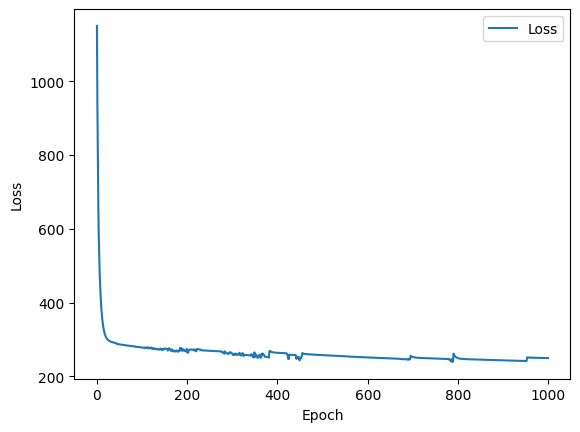

Output Layer:  (309, 1)
[[29.5845687 ]
 [34.82862702]
 [34.82862702]
 [34.82862702]
 [34.82862702]
 [38.27068305]
 [38.56585714]
 [34.82862702]
 [43.80976799]
 [38.85836547]
 [34.82862702]
 [43.80976799]
 [34.82862702]
 [34.82862702]
 [34.82862702]
 [34.82862702]
 [34.82862702]
 [34.82862702]
 [34.82862702]
 [34.82862702]
 [34.82862702]
 [34.82862702]
 [34.82862702]
 [34.82862702]
 [29.5845687 ]
 [34.82862702]
 [29.5845687 ]
 [34.82862702]
 [34.82862702]
 [29.5845687 ]
 [39.58422203]
 [29.58549398]
 [34.82862702]
 [39.58422203]
 [38.56570967]
 [34.82862702]
 [34.82862702]
 [34.82862702]
 [34.82862702]
 [43.80976799]
 [34.82862702]
 [43.80976799]
 [34.82862702]
 [30.50873671]
 [34.82862702]
 [34.82862702]
 [43.80976799]
 [34.82862702]
 [34.82862702]
 [39.58422203]
 [34.82862702]
 [34.82862702]
 [34.82862702]
 [34.82862702]
 [34.82862702]
 [35.75279503]
 [34.82862702]
 [39.58422203]
 [34.82866617]
 [34.82862702]
 [34.82862702]
 [34.82862702]
 [34.82862702]
 [34.82862702]
 [34.82862702]
 

In [4]:
# Create a Instance of The N.N class
Neural_Network = ThreeLayerNeuralNetwork(input_nodes=8, hidden_nodes=50, output_nodes=1, learning_rate=0.001, activation_function='sigmoid', Optimizer='SGD')

# # Normalize the Data
# X_Train = X_Train/np.amax(X_Train, axis=0)
# Y_Train = Y_Train/np.amax(Y_Train, axis=0)

Neural_Network.Train(X_Train, Y_Train, epochs=1000)
print(Neural_Network.Test(x_test))
print(y_test)

# y_pred = []

# # Find the Loss on the Test Data
# for i in range(len(x_test)):
#     y_pred.append(Neural_Network.Test(x_test[i]))

# # Calculate the Loss
# Loss = 0
# for i in range(len(y_test)):
#     Loss += Neural_Network._loss_function(y_test[i], y_pred[i])

# print('Loss on Test Data: ', Loss/len(y_test))
